# Objectives:
For each Featurization(BOWs, TF-IDF, AVG-W2V, TF-IDF W2V) we need to split the data based on Time Based Slicing and apply KNN and find test accurcy.

Use 10-Fold Cross Validation to determine optimal k and find test accuracy.

Try the same with KD-Tree and Brute Force algo and compare the results.

# Loading Libraries

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import gensim
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [71]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [72]:
filtered_data.shape

(525814, 10)

In [73]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [74]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# sort reviews based on ProductId

In [75]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
# Remove duplicate reviews

(364173, 10)

In [76]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [77]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [78]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [79]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [80]:
final['CleanedText']=final_string

# Sort The Data Based On Time

In [81]:
final = final.sort_values(['Time'], ascending=[True])
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'this witti littl book make son laugh loud re...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'can rememb see the show when air televis yea...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth about e...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel and funni movi keaton hilar...


In [15]:
positive_50000=final.loc[final['Score'] == "positive"].tail(50000)
negative_50000=final.loc[final['Score'] == "negative"].tail(50000)
pos_neg_1l = pd.concat([positive_50000, negative_50000], axis=0)
labels = pos_neg_1l['Score']

# Sort the sample values based on time

In [16]:
pos_neg_1l = pos_neg_1l.sort_values(['Time'], ascending=[True])
pos_neg_1l.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
288768,312780,B000FPFC4O,A77EO8HXDT3II,"Sawyer ""book lover""",1,1,negative,1248825600,Disappointing,I was very disappointed in the taste of these ...,b'was veri disappoint the tast these cooki ver...
192576,208809,B00004RAMV,A1RVL257CTT821,Carrie Armstrong,1,5,negative,1248825600,no bees,"I did what the guidlines suggested, and no bee...",b'did what the guidlin suggest and bee came ad...
177947,192959,B000ILA4KW,AQ5JDBXICB18J,R. Culp,0,0,negative,1248825600,Not impressed,I didn't have much luck with this popcorn in t...,b'didnt have much luck with this popcorn the m...
78622,85503,B002DHTWNO,A4UP3MT4NWCSS,"A. Tabachnik ""IDF""",9,13,negative,1248825600,The item contains MSG,The description for the item is wrong.<br />It...,b'the descript for the item wrong doe contain ...
114848,124563,B000UZLQG2,AQ5JDBXICB18J,R. Culp,1,3,negative,1248825600,Buttery flavor ???,Tastes too much like regular oil for me. I'm s...,b'tast too much like regular oil for still loo...


In [17]:
X = pos_neg_1l['CleanedText']
y = pos_neg_1l['Score']

In [18]:
# to store these objects in a file

# import pickle
# pickle_out = open("X.pickle","wb")
# pickle.dump(X, pickle_out)
# pickle_out.close()
# pickle_out = open("y.pickle","wb")
# pickle.dump(y, pickle_out)
# pickle_out.close()

In [3]:
# to get load X and y from pickle objects

# import pickle
# pickle_in = open("X.pickle","rb")
# X = pickle.load(pickle_in)
# pickle_in = open("y.pickle","rb")
# y = pickle.load(pickle_in)

In [4]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
# BoW: A bag-of-words model, or BoW for short, is a way of extracting features from 
#      text for use in modeling, such as with machine learning algorithms.
#      It is called a “bag” of words, because any information about the order or structure of words 
#      in the document is discarded. The model is only concerned with whether known words occur in the document,
#      not where in the document.

# https://machinelearningmastery.com/gentle-introduction-bag-words-model/

# CountVectorizer: Convert a collection of text documents to a matrix of token counts.
#                  This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

In [5]:
# code for Bag Of Words calculation
count_vect = CountVectorizer()
# calculate BOW of trainning data
X_train = count_vect.fit_transform(X_train)
# transform test data
X_test = count_vect.transform(X_test)

In [23]:
# StandardScaler: Transforming data so that mean becomes 0 and std-dev becomes 1(so that to follow Gaussian Distribution)
# The StandardScaler applies the transformation  fnew=(f−f¯)/σf  to each dimension, 
# where  f¯  is the mean and  σf  the standard deviation for that dimension. 
# This will result in each dimension having a mean of 0 and a standard deviation of 1.
# Please note that when our data is stored in a sparse matrix, for instance when 
# we have a DictVectorizer or a CountVectorizer, the StandardScaler will be created with 
# the option with_mean=False. This means that we don't subtract  f¯ . The reason is 
# that we want to keep the matrix sparse: if an entry was zero before the transformation,
# we'd like it to be zero after the transformation also.

# the call fit_transform consists of a call to fit and then to transform. 
# In this case, fit will compute the mean and standard deviation, and then transform will apply the formula mentioned above.

In [6]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# fit trainning data to the classifiers
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
# test score
classifier.score(X_test, y_test)

0.6801666666666667

In [ ]:
# train score
classifier.score(X_train , y_train)

In [9]:
y_pred = classifier.predict(X_test)

Confusion matrix, without normalization
[[ 9254  5691]
 [ 3904 11151]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.26  0.74]]


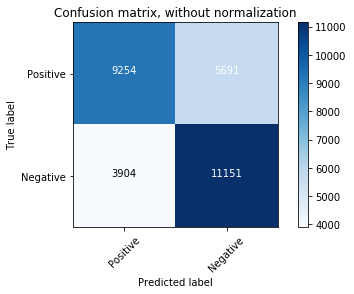

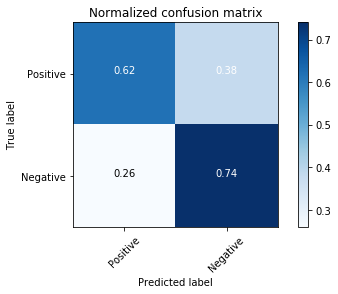

In [10]:
# The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Observation:
The diagonal elements represent the number of points for which the predicted label is equal to the true label,

while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of

the confusion matrix the better, indicating many correct predictions.

without normalization: Total (9254 + 11151) Points out of 30000(Test Points) are predicted correct. so the accurecy is pretty low (68%) with k = 5

# Apply KNN with KD-TREE

In [11]:
# we have used a parameter called algorithm as 'kd_tree' 
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', algorithm = 'kd_tree',  p = 2)
classifier.fit(X_train, y_train)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [12]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 68%


Confusion matrix, without normalization
[[ 9254  5691]
 [ 3904 11151]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.26  0.74]]


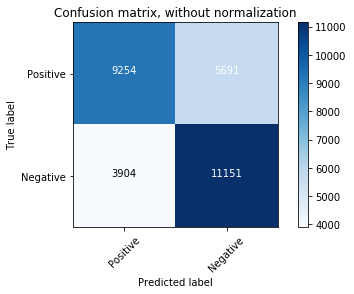

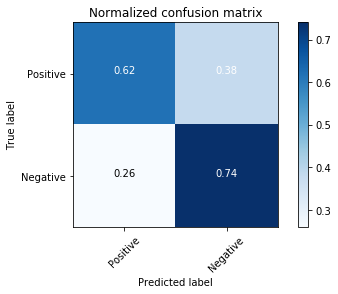

In [14]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Observations:

Kd-Tree and Auto gives same accurecy.

# Apply KNN with BruteForce Algorithm:

In [15]:
# we have used a parameter called algorithm as 'brute'. which will use a brute-force search.
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', algorithm = 'brute',  p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 68%


Confusion matrix, without normalization
[[ 9254  5691]
 [ 3904 11151]]
Normalized confusion matrix
[[ 0.62  0.38]
 [ 0.26  0.74]]


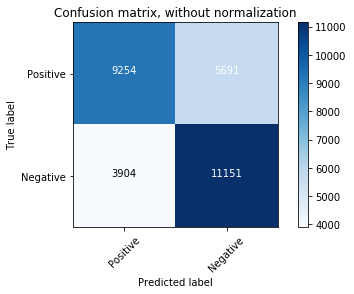

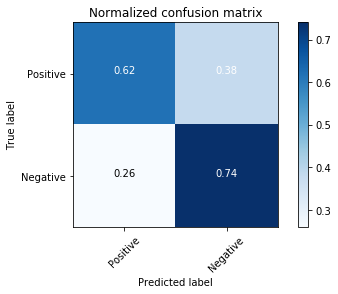

In [18]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# 10 fold cross validation BOW

In [19]:
# load precomputed cv_score

# import pickle
# pickle_in = open("cvscore.pickle","rb")
# cv_scores = pickle.load(pickle_in)


The optimal number of neighbors is 49.


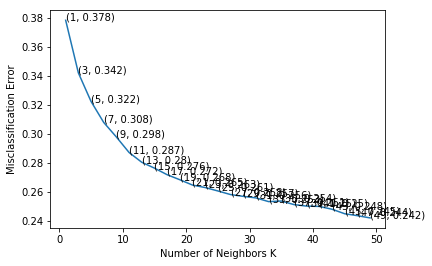

the misclassification error for each k value is :  [ 0.38  0.34  0.32  0.31  0.3   0.29  0.28  0.28  0.27  0.27  0.27  0.26
  0.26  0.26  0.26  0.26  0.25  0.25  0.25  0.25  0.25  0.25  0.24  0.24
  0.24]


In [20]:
# from sklearn.cross_validation import cross_val_score
# # creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
# cv_scores = []

# # perform 10-fold cross validation
# for k in neighbors:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [21]:
# pickle cv_score in a file

# pickle_out = open("cvscore.pickle","wb")
# pickle.dump(cv_scores, pickle_out)
# pickle_out.close()

# Observation:

here we have used 10-fold cross validation to get optimal value of k.

with k=49 we will have better accurecy.

In [22]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
y_pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, y_pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 49 is 75.993333%


In [23]:
# test score

knn_optimal.score(X_test, y_test)

0.75993333333333335

In [ ]:
# train score

knn_optimal.score(X_train , y_train)

# Observation:

it's a resonable gain from 68% to 76% with optimal k of 49.

# TFIDF with KNN:

In [24]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.3, random_state=0)

In [25]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(X_train_tfidf)
final_tf_idf_test = tf_idf_vect.transform(X_test_tfidf)

In [26]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(final_tf_idf_train)
# transform both train and test data
final_tf_idf_train = scaler.transform(final_tf_idf_train)
final_tf_idf_test = scaler.transform(final_tf_idf_test)

In [27]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(final_tf_idf_train, y_train_tfidf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
# Predicting the Test set results
y_pred = classifier.predict(final_tf_idf_test)

In [29]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 51%


Confusion matrix, without normalization
[[  310 14635]
 [   43 15012]]
Normalized confusion matrix
[[ 0.02  0.98]
 [ 0.    1.  ]]


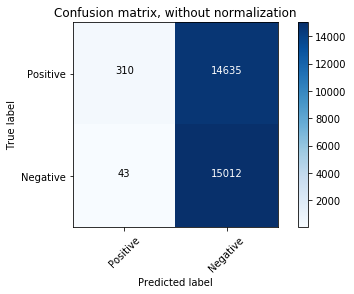

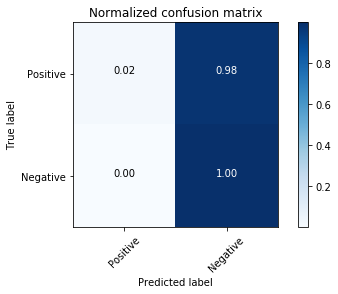

In [30]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_tfidf, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Observations:
applying KNN with TF-IDF reduced the accurecy to 51%. Lets try to find optimal k with 10-fold cv.

# 10 fold cross validation TF-IDF

In [31]:
# get cvscore 

# import pickle
# pickle_in = open("cvscore_tfidf.pickle","rb")
# cv_scores_tfidf = pickle.load(pickle_in)


The optimal number of neighbors is 1.


/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


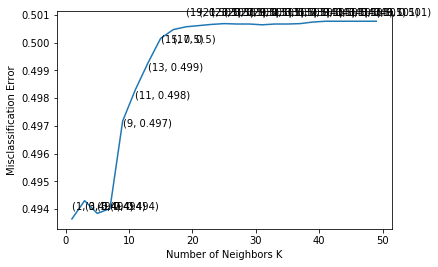

the misclassification error for each k value is :  [ 0.49  0.49  0.49  0.49  0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5
  0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5   0.5
  0.5 ]


In [32]:
from sklearn.cross_validation import cross_val_score
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# # empty list that will hold cv scores
# cv_scores = []

# # perform 10-fold cross validation
# for k in neighbors:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X_train_tfidf, y_train_tfidf, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores_tfidf]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [33]:
# dump cv-score in a file

# pickle_out = open("cvscore_tfidf.pickle","wb")
# pickle.dump(cv_scores, pickle_out)
# pickle_out.close()

In [34]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(final_tf_idf_train, y_train_tfidf)

# predict the response
y_pred = knn_optimal.predict(final_tf_idf_test)

# evaluate accuracy
acc = accuracy_score(y_test_tfidf, y_pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 1 is 50.546667%


# Observations:
It seems there is no optimal k. it's same for all k. lets try with KD-Tree.

# Apply KNN with KD-TREE - TF-IDF

In [37]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', algorithm = 'kd_tree', p = 2)
classifier.fit(final_tf_idf_train, y_train_tfidf)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [38]:
# Predicting the Test set results
y_pred = classifier.predict(final_tf_idf_test)

Confusion matrix, without normalization
[[  310 14635]
 [   43 15012]]
Normalized confusion matrix
[[ 0.02  0.98]
 [ 0.    1.  ]]


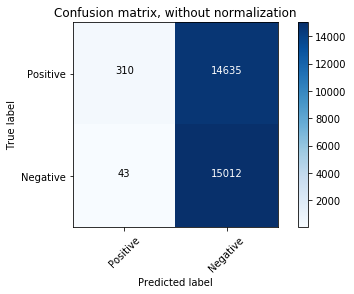

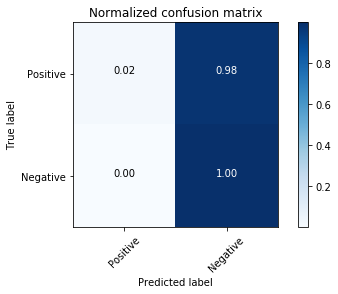

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_tfidf, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Apply KNN with BruteForce Algorithm TF-IDF:

In [41]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', algorithm = 'brute', p = 2)
classifier.fit(final_tf_idf_train, y_train_tfidf)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [42]:
# Predicting the Test set results
y_pred = classifier.predict(final_tf_idf_test)

Confusion matrix, without normalization
[[  310 14635]
 [   43 15012]]
Normalized confusion matrix
[[ 0.02  0.98]
 [ 0.    1.  ]]


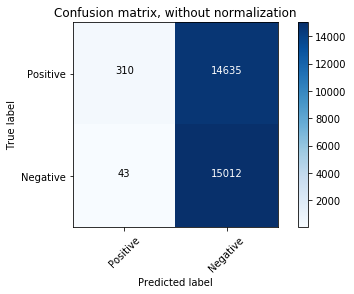

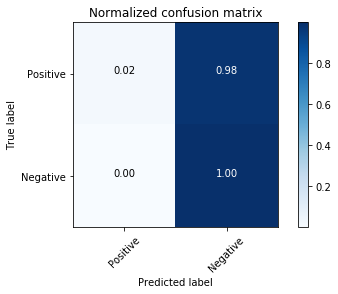

In [43]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_tfidf, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Avg W2V with KNN:

In [44]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X, y, test_size=0.3, random_state=0)

In [47]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [48]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [49]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [50]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [51]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


30000
50


In [52]:
df_train = pd.DataFrame(sent_vectors)
df_train = df_train.fillna(df_train.mean())
df_test = pd.DataFrame(sent_vectors_test)
df_test = df_test.fillna(df_test.mean())
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_train_avgw2v = scaler.transform(df_train)
standardized_data_test_avgw2v = scaler.transform(df_test)

In [53]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(standardized_data_train_avgw2v, y_train_avgw2v)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
# Predicting the Test set results
y_pred = classifier.predict(standardized_data_test_avgw2v)

Confusion matrix, without normalization
[[12263  2682]
 [ 3541 11514]]
Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.24  0.76]]


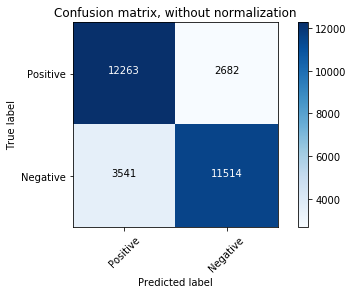

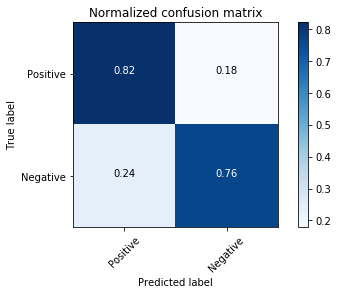

In [55]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_avgw2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [56]:
classifier.score(standardized_data_test_avgw2v, y_test_avgw2v)

0.79256666666666664

In [57]:
classifier.score(standardized_data_train_avgw2v , y_train_avgw2v)

0.86251428571428568

# Observation:

its a huge gain since BOW and TF-IDF. Accurecy reached to 79%.

# 10 fold cross validation- Avg W2V


The optimal number of neighbors is 31.


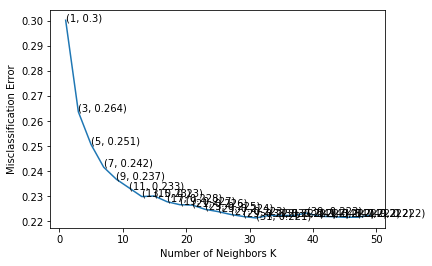

the misclassification error for each k value is :  [ 0.3   0.26  0.25  0.24  0.24  0.23  0.23  0.23  0.23  0.23  0.23  0.23
  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22
  0.22]


In [58]:
from sklearn.cross_validation import cross_val_score
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# # empty list that will hold cv scores
# cv_scores = []

# # perform 10-fold cross validation
# for k in neighbors:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, standardized_data_train_avgw2v, y_train_avgw2v, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())
import pickle
pickle_in = open("cvscore_avgw2v.pickle","rb")
cv_scores = pickle.load(pickle_in)

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [59]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(standardized_data_train_avgw2v, y_train_avgw2v)

# predict the response
pred = knn_optimal.predict(standardized_data_test_avgw2v)

# evaluate accuracy
acc = accuracy_score(y_test_avgw2v, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 31 is 81.953333%


# Observation:
With Optimal K = 31 we have accurecy ~82%. which was 3% higher than default k = 5.

# Avg W2V with KNN - KD-Tree:

In [60]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', algorithm = 'kd_tree', p = 2)
classifier.fit(standardized_data_train_avgw2v, y_train_avgw2v)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [61]:
# Predicting the Test set results
y_pred = classifier.predict(standardized_data_test_avgw2v)

Confusion matrix, without normalization
[[12263  2682]
 [ 3541 11514]]
Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.24  0.76]]


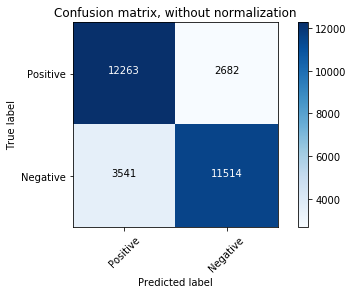

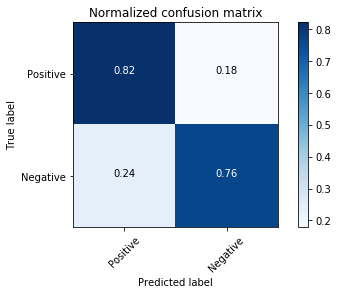

In [62]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_avgw2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [63]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_avgw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 79%


In [64]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(standardized_data_train_avgw2v, y_train_avgw2v)

# predict the response
pred = knn_optimal.predict(standardized_data_test_avgw2v)

# evaluate accuracy
acc = accuracy_score(y_test_avgw2v, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 31 is 81.953333%


In [ ]:
classifier.score(standardized_data_train_avgw2v , y_train_avgw2v)

# Avg W2V with KNN - Brute Force Algorithm:

In [65]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', algorithm = 'brute', p = 2)
classifier.fit(standardized_data_train_avgw2v, y_train_avgw2v)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [66]:
# Predicting the Test set results
y_pred = classifier.predict(standardized_data_test_avgw2v)

Confusion matrix, without normalization
[[12263  2682]
 [ 3541 11514]]
Normalized confusion matrix
[[ 0.82  0.18]
 [ 0.24  0.76]]


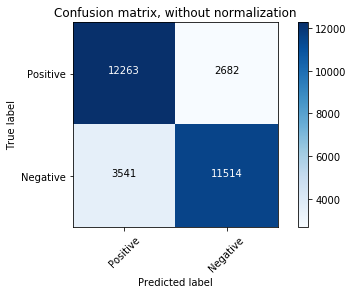

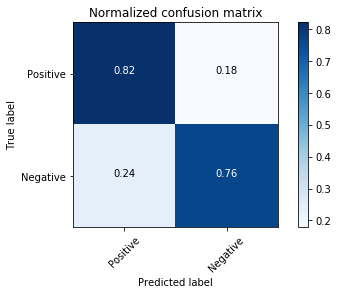

In [67]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_avgw2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [68]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_avgw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 79%


In [69]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(standardized_data_train_avgw2v, y_train_avgw2v)

# predict the response
pred = knn_optimal.predict(standardized_data_test_avgw2v)

# evaluate accuracy
acc = accuracy_score(y_test_avgw2v, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 31 is 81.953333%


# For TFIDF-W2V taking 40K data

# calculating W2V for 40K

In [82]:
positive_20000=final.loc[final['Score'] == "positive"].tail(20000)
negative_20000=final.loc[final['Score'] == "negative"].tail(20000)
pos_neg_40k = pd.concat([positive_20000, negative_20000], axis=0)
labels = pos_neg_40k['Score']

In [83]:
pos_neg_40k = pos_neg_40k.sort_values(['Time'], ascending=[True])
pos_neg_40k.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
261899,283904,B00455GM9E,A1FBLR62DJ46L3,MaryAnne,0,1,negative,1327968000,Too Sweet,It is ok as long as you only use half as much ...,b'long you onli use half much syrup call for a...
454702,491596,B001M1Z1EQ,A6KCWLEG41R4J,Ms Sensitive,0,0,negative,1327968000,Unpleasant product,The bread pudding I received was in different ...,b'the bread pud receiv was differ packag than ...
205284,222415,B004E4CCSQ,A2SZLNSI5KOQJT,"Carrie, ""Formerly &#34;Sister Carrie&#34;""",0,1,negative,1327968000,OK Taste. Fuzzy-Peachy Flavor. But Also a Ch...,The MIO Peach Tea flavor is definitely a fuzzy...,b'the mio peach tea flavor definit fuzzi peach...
326016,352840,B001SAY7BO,A6L0WHWTB31OC,"A. M. Smith ""morg999""",2,2,negative,1327968000,Amazingly BAD....,I would like to start by saying that I have ne...,b'would like start say that have never written...
86027,93669,B004IJMVQA,A4OD6YMH5FLV5,S. Montane,1,1,negative,1327968000,Yuck.,"I love Peanut Butter Puffins, but this is not ...",b'love peanut butter puffin but this not nor d...


In [84]:
X = pos_neg_40k['CleanedText']
y = pos_neg_40k['Score']

In [85]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X, y, test_size=0.3, random_state=0)

In [86]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [87]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [88]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

# TFIDF-W2V with KNN:

In [89]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_tfidfw2v, X_test_tfidfw2v, y_train_tfidfw2v, y_test_tfidfw2v = train_test_split(X, y, test_size=0.3, random_state=0)

In [90]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train_tfidfw2v)

##### calculate TF-IDF weighted Word2Vec for train data

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
                                     #obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [ ]:
# import pickle
# pickle_out = open("train_w2vtfidf.pickle","wb")
# pickle.dump(tfidf_sent_vectors, pickle_out)
# pickle_out.close()

In [91]:
import pickle
pickle_in = open("train_w2vtfidf.pickle","rb")
tfidf_sent_vectors = pickle.load(pickle_in)

##### calculate TF-IDF weighted Word2Vec for test data

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
                                     #obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [ ]:
# pickle_out = open("test_w2vtfidf.pickle","wb")
# pickle.dump(tfidf_sent_vectors_test, pickle_out)
# pickle_out.close()

In [92]:
pickle_in = open("test_w2vtfidf.pickle","rb")
tfidf_sent_vectors_test = pickle.load(pickle_in)

##### Do standadization for train and test vectors

In [93]:
df_train = pd.DataFrame(tfidf_sent_vectors)
df_train = df_train.fillna(df_train.mean())
df_test = pd.DataFrame(tfidf_sent_vectors_test)
df_test = df_test.fillna(df_test.mean())

from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_tf_idfw2v_train = scaler.transform(df_train)
standardized_data_tf_idfw2v_test = scaler.transform(df_test)

In [94]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(standardized_data_tf_idfw2v_train, y_train_tfidfw2v)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [95]:
# Predicting the Test set results
y_pred = classifier.predict(standardized_data_tf_idfw2v_test)

Confusion matrix, without normalization
[[4432 1552]
 [3564 2452]]
Normalized confusion matrix
[[ 0.74  0.26]
 [ 0.59  0.41]]


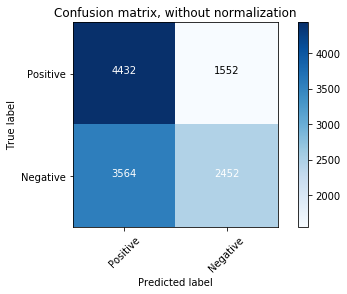

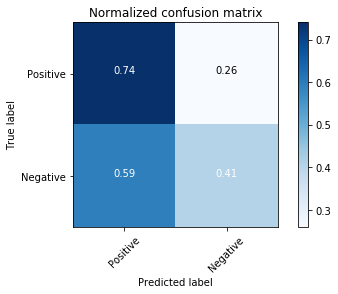

In [96]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_tfidfw2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [97]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidfw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 57%


# 10 fold cross validation- TF-IDF W2V KNN:

In [98]:
# pickle_out = open("cvscore_w2vtfidf.pickle","wb")
# pickle.dump(cv_scores, pickle_out)
# pickle_out.close()

pickle_in = open("cvscore_w2vtfidf.pickle","rb")
cv_scores = pickle.load(pickle_in)


The optimal number of neighbors is 31.


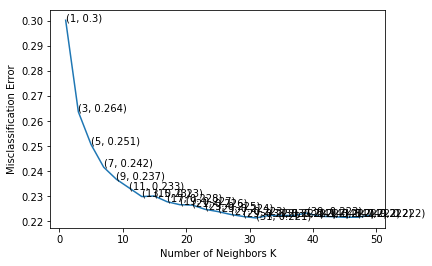

the misclassification error for each k value is :  [ 0.3   0.26  0.25  0.24  0.24  0.23  0.23  0.23  0.23  0.23  0.23  0.23
  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22  0.22
  0.22]


In [99]:
from sklearn.cross_validation import cross_val_score
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# # empty list that will hold cv scores
# cv_scores = []

# # perform 10-fold cross validation
# for k in neighbors:
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, standardized_data_tf_idfw2v_train, y_train_tfidfw2v, cv=10, scoring='accuracy')
#     cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [100]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(standardized_data_tf_idfw2v_train, y_train_tfidfw2v)

# predict the response
pred = knn_optimal.predict(standardized_data_tf_idfw2v_test)

# evaluate accuracy
acc = accuracy_score(y_test_tfidfw2v, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 31 is 58.483333%


In [107]:
knn_optimal.score(standardized_data_tf_idfw2v_train, y_train_tfidfw2v)

0.79889285714285718

# TFIDF-W2V with KNN-KD-Tree:

In [102]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', algorithm = 'kd_tree', p = 2)
classifier.fit(standardized_data_tf_idfw2v_train, y_train_tfidfw2v)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [103]:
# Predicting the Test set results
y_pred = classifier.predict(standardized_data_tf_idfw2v_test)

Confusion matrix, without normalization
[[4432 1552]
 [3564 2452]]
Normalized confusion matrix
[[ 0.74  0.26]
 [ 0.59  0.41]]


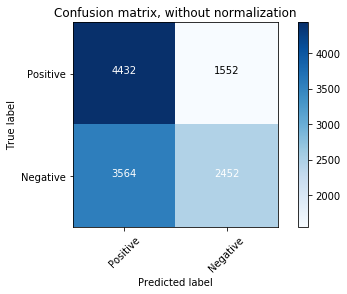

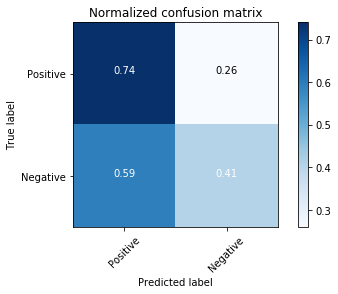

In [104]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_tfidfw2v, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Positive','Negative'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [105]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidfw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 5 is %d%%' % (acc))


****Test accuracy for k = 5 is 57%


# Conclusion:
After performing KNN with each featurization(BOW,TF-IDF,AVG w2V, TF-IDF W2V) we could see KNN with AVG W2V gives better accuracy(~82%) with optimal k. here we have applied 10-Fold cross validation to determine Opimal k and apply it then accuracy increases because we are using cross validation set also as a training set. More data we have more information and hence increases prediction probability.

In [108]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "hyper parameter- K", "train error", "test error"]
x.add_row(["K-NN-BOW", 49, "", "25%"])
x.add_row(["K-NN-TFIDF", 1, "", "49%"])
x.add_row(["K-NN-AVGW2V", 31, "16%", "18%"])
x.add_row(["K-NN-TFIDFAVGW2V", 31, "21%", "42%"])
print("Featurization With KNN:")
print(x)

Featurization With KNN:
+------------------+--------------------+-------------+------------+
|      Model       | hyper parameter- K | train error | test error |
+------------------+--------------------+-------------+------------+
|     K-NN-BOW     |         49         |             |    25%     |
|    K-NN-TFIDF    |         1          |             |    49%     |
|   K-NN-AVGW2V    |         31         |     16%     |    18%     |
| K-NN-TFIDFAVGW2V |         31         |     21%     |    42%     |
+------------------+--------------------+-------------+------------+
